# Controllable Level Blending Using VAE (v1) Notebook

**Description** 

This notebook contains code for both training and analyzing VAE for blending SMB and KI chunks.

**Table of Content**
- Load modules (run each time)
- Train old VAE
    - Define hyper-parameters (run each time)
    - Load data (run each time)
    - Start training
- Analyze old VAE
    - Method 1 - Density-difficulty plot

# Load modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../modules')

In [3]:
import json
import numpy as np
from scipy.stats import entropy
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from data_utils import WrappedDataLoader, preprocess
from model import get_model
from model_fixed import load_model

In [4]:
def array_from_json(path:str):
    with open(path) as f:
        chunks = np.array(json.load(f))
    print(f'{len(chunks)} chunks loaded from {path}.')
    return chunks

In [7]:
char_to_int = { "X": 0,
                "S": 1,
                "-": 2,
                "?": 3,
                "Q": 4,
                "E": 5,
                "<": 6,
                ">": 7,
                "[": 8,
                "]": 9,
                "o": 10,
                "T": 11,
                "M": 12,
                "D": 13,
                "#": 14,
                "H": 15,
                "*": 16
              }

int_to_char = {v:k for k, v in char_to_int.items()}

tiles_path = '../data/tiles'

chars_to_pngs_gen = {
    "#": Image.open(f'{tiles_path}/ki-unpassable.png'),
    "T": Image.open(f'{tiles_path}/ki-passable.png'),
    "M": Image.open(f'{tiles_path}/ki-moving-platform.png'),
    
    "H": Image.open(f'{tiles_path}/ki-hazard.png'),

    "*": Image.open(f'{tiles_path}/ki-background.png'),
    "D": Image.open(f'{tiles_path}/ki-door.png'),
    
    "-": Image.open(f'{tiles_path}/smb-background.png'),
    "X": Image.open(f'{tiles_path}/smb-unpassable.png'),
    "S": Image.open(f'{tiles_path}/smb-breakable.png'),
    
    "?": Image.open(f'{tiles_path}/smb-question.png'),
    "Q": Image.open(f'{tiles_path}/smb-question.png'),
    "o": Image.open(f'{tiles_path}/smb-coin.png'),
    "E": Image.open(f'{tiles_path}/smb-enemy.png'),
    
    "<": Image.open(f'{tiles_path}/smb-tube-top-left.png'),
    ">": Image.open(f'{tiles_path}/smb-tube-top-right.png'),
    "[": Image.open(f'{tiles_path}/smb-tube-lower-left.png'),
    "]": Image.open(f'{tiles_path}/smb-tube-lower-right.png')
    }

In [8]:
def array_to_image(array):
    """
    Convert a 16-by-16 array of integers into a PIL.Image object
    param: array: a 16-by-16 array of integers
    """
    image = Image.new('RGB',(16 * 16, 16 * 16))
    for i in array:
        for row, seg in enumerate(i):
            for col, tile in enumerate(seg):
                image.paste(chars_to_pngs_gen[int_to_char[tile]], (col * 16, row * 16))
    return image

# Train Old VAE

## Define hyper-parameters

**Config 1**
- SMB has movable platforms
- Empty and full questions in SMB are merged

In [6]:
hp = {
    'nepoch': 10000,
    'z_dim': 64,
    'nc': 16,
    'dev': torch.device('cuda'),
    'bs': 32,
}

In [7]:
smb_json_path = 'data/smb_chunks_onehot.json'
ki_json_path = 'data/ki_chunks_onehot.json'

**Config 2**
- SMB does not have movable platforms
- Empty and full questions in SMB are still merged

In [8]:
hp = {
    'nepoch': 10000,
    'z_dim': 64,
    'nc': 16,
    'dev': torch.device('cuda'),
    'bs': 32,
}

In [9]:
smb_json_path = 'data/smb_1_1_chunks_onehot.json'
ki_json_path = 'data/ki_5_chunks_onehot.json'
model_name = 'trained_models/vae_old_old_encoding.pth'
csv_name = 'training_csvs/vae_old_old_encoding.csv'
validation = False

**Load JSON into array for Config 1 and Config 2**

In [13]:
smb_chunks = array_from_json(smb_json_path)

187 chunks loaded from data/smb_1_1_chunks_onehot.json.


In [14]:
ki_chunks = array_from_json(ki_json_path)

190 chunks loaded from data/ki_5_chunks_onehot.json.


In [15]:
train_chunks = np.concatenate([smb_chunks, ki_chunks], axis=0)

if validation:
    valid_chunks = np.concatenate([smb_chunks[187:], ki_chunks[190:]], axis=0)

**Config 3** - 19/07/19
- SMB DO NOT have movable platforms
- Empty and full questions in SMB are NOT merged

In [12]:
hp = {
    'nepoch': 10000,
    'z_dim': 64,
    'nc': 17,
    'dev': torch.device('cuda'),
    'bs': 32,
}

smb_json_path = '../data/smb-1-1-org-chunks-onehot.json'
smb_chunks = array_from_json(smb_json_path)

ki_json_path = '../data/ki-5-org-chunks-onehot.json'
ki_chunks = array_from_json(ki_json_path)

train_chunks = np.concatenate([smb_chunks, ki_chunks], axis=0)

model_name = 'trained_models/vae_old_encoding_v3.pth'
csv_name = 'training_csvs/vae_old_encoding_v3.csv'

187 chunks loaded from ../data/smb-1-1-org-chunks-onehot.json.
191 chunks loaded from ../data/ki-5-org-chunks-onehot.json.


In [13]:
print(len(np.unique(np.argmax(train_chunks, axis=1))))

16


In [14]:
char_to_int = { "X": 0,
                "S": 1,
                "-": 2,
                "?": 3,
                "Q": 4,
                "E": 5,
                "<": 6,
                ">": 7,
                "[": 8,
                "]": 9,
                "o": 10,
                "T": 11,
                "M": 12,
                "D": 13,
                "#": 14,
                "H": 15,
                "*": 16
              }

In [15]:
print('Items in encoding:', np.unique(np.argmax(train_chunks, axis=1)))
print('Number of items:', len(np.unique(np.argmax(train_chunks, axis=1))))

Items in encoding: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16]
Number of items: 16


In [16]:
validation = False

## Load data

In [11]:
train_chunks.shape

(378, 17, 16, 16)

In [12]:
train_chunks = torch.from_numpy(train_chunks)
if validation:
    valid_chunks = torch.from_numpy(valid_chunks)

In [13]:
train_ds = TensorDataset(train_chunks, train_chunks)
train_dl = DataLoader(train_ds, batch_size=hp['bs'], shuffle=True)
train_dl = WrappedDataLoader(train_dl, preprocess)

if validation: 
    valid_ds = TensorDataset(valid_chunks, valid_chunks)
    valid_dl = DataLoader(valid_ds, batch_size=hp['vbs'], shuffle=False)
    valid_dl = WrappedDataLoader(valid_dl, preprocess)

## Check the availability of GPUs

In [17]:
torch.cuda.is_available()

False

## Define loss functions

In [135]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / recon_x.size(0)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # already averaged over examples
    return BCE + KLD, BCE, KLD

In [136]:
def loss_fn_separate(recon_x, x, c, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x[:,c,:,:], x[:,c,:,:], reduction='sum') / recon_x.size(0)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # already averaged over examples
    return BCE + KLD, BCE, KLD

## Start training

In [137]:
import warnings
warnings.filterwarnings('ignore')

In [138]:
vae, opt = get_model(dev=hp['dev'], z_dim=hp['z_dim'], nc=hp['nc'])
    
loss_h, bce_h, kld_h = [], [], []
vloss_h, vbce_h, vkld_h = [], [], []
loss_per_type = [[] for i in range(hp['nc'])]

i = 0; 
for i in range(hp['nepoch']):
    i += 1  # start with epoch one instead of zero

    vae.train()  # enter training mode
    
    tot_loss, tot_bce, tot_kld = 0, 0, 0
    for xb, yb in train_dl:

        opt.zero_grad()
        
        recon, mu, logvar = vae(xb)
        loss, bce, kld = loss_fn(recon, yb, mu, logvar)

        tot_loss += loss.data.item() 
        tot_bce += bce.data.item()
        tot_kld += kld.data.item()
  
        loss.backward()
        opt.step()
    
    if i % 10 == 0:
        progress_tag = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(i,
                                                                        hp['nepoch'], 
                                                                        tot_loss / len(train_dl), 
                                                                        tot_bce / len(train_dl), 
                                                                        tot_kld / len(train_dl))
        print(progress_tag)

    # average loss across batches (across examples)
    loss_h.append(tot_loss / len(train_dl))
    bce_h.append(tot_bce / len(train_dl))
    kld_h.append(tot_kld / len(train_dl))

    vae.eval()  # enter validation mode
    
    if validation:
        if i % 10 == 0:
            with torch.no_grad():
                tot_loss, tot_bce, tot_kld = 0, 0, 0
                tot_loss_per_type = [0 for i in range(hp['nc'])]
                for xb, yb in valid_dl:
                    recon, mu, logvar = vae(xb)
                    loss, bce, kld = loss_fn(recon, yb, mu, logvar)
                    tot_loss += loss
                    tot_bce += bce
                    tot_kld += kld

                    for j in range(hp['nc']):
                        loss, bce, kld = loss_fn_separate(recon, yb, j, mu, logvar)
                        tot_loss_per_type[j] += loss

                progress_tag = "Epoch[{}/{}] VLoss: {:.3f} {:.3f} {:.3f}".format(i,
                                                                                 hp['nepoch'], 
                                                                                 tot_loss / len(valid_dl), 
                                                                                 tot_bce / len(valid_dl), 
                                                                                 tot_kld / len(valid_dl))
                print(progress_tag)
                vloss_h.append(tot_loss / len(valid_dl))
                vbce_h.append(tot_loss / len(valid_dl))
                vkld_h.append(tot_loss / len(valid_dl))

                for k in range(hp['nc']):
                    tot_loss_per_type[k] /= len(valid_dl)
                    loss_per_type[k].append(tot_loss_per_type[k])
            

if validation:
    vloss_df = pd.DataFrame(np.array([vloss_h, vbce_h, vkld_h]).T)
    vloss_df.columns = ['vloss', 'vbce', 'vkld']
    vloss_df.to_csv('training_csvs/vae_old_new_encoding_valid.csv')

loss_df = pd.DataFrame(np.array([loss_h, bce_h, kld_h]).T)
loss_df.columns = ['loss', 'bce', 'kld']
loss_df.to_csv(csv_name)

torch.save(vae.state_dict(), model_name)

Epoch[10/10000] Loss: 350.404 349.201 1.203
Epoch[20/10000] Loss: 266.615 265.684 0.931
Epoch[30/10000] Loss: 207.211 206.039 1.172
Epoch[40/10000] Loss: 157.296 155.618 1.677
Epoch[50/10000] Loss: 101.964 99.967 1.998
Epoch[60/10000] Loss: 66.582 64.367 2.215
Epoch[70/10000] Loss: 46.952 44.724 2.228
Epoch[80/10000] Loss: 37.328 35.057 2.271
Epoch[90/10000] Loss: 29.367 27.184 2.184
Epoch[100/10000] Loss: 23.420 21.256 2.165
Epoch[110/10000] Loss: 18.890 16.768 2.122
Epoch[120/10000] Loss: 16.196 14.111 2.085
Epoch[130/10000] Loss: 14.026 11.954 2.072
Epoch[140/10000] Loss: 13.470 11.415 2.056
Epoch[150/10000] Loss: 11.807 9.700 2.107
Epoch[160/10000] Loss: 8.849 6.908 1.941
Epoch[170/10000] Loss: 7.553 5.668 1.886
Epoch[180/10000] Loss: 15.058 12.402 2.656
Epoch[190/10000] Loss: 8.170 6.077 2.093
Epoch[200/10000] Loss: 6.356 4.392 1.964
Epoch[210/10000] Loss: 5.535 3.681 1.854
Epoch[220/10000] Loss: 5.507 3.697 1.809
Epoch[230/10000] Loss: 4.691 2.929 1.762
Epoch[240/10000] Loss: 4.7

Epoch[1980/10000] Loss: 1.730 0.826 0.904
Epoch[1990/10000] Loss: 2.129 1.200 0.928
Epoch[2000/10000] Loss: 2.375 1.034 1.341
Epoch[2010/10000] Loss: 4.321 3.149 1.172
Epoch[2020/10000] Loss: 2.066 0.843 1.223
Epoch[2030/10000] Loss: 1.885 0.832 1.053
Epoch[2040/10000] Loss: 1.822 0.833 0.989
Epoch[2050/10000] Loss: 1.839 0.896 0.944
Epoch[2060/10000] Loss: 1.785 0.832 0.953
Epoch[2070/10000] Loss: 1.751 0.836 0.915
Epoch[2080/10000] Loss: 1.697 0.789 0.908
Epoch[2090/10000] Loss: 1.742 0.852 0.889
Epoch[2100/10000] Loss: 1.728 0.853 0.875
Epoch[2110/10000] Loss: 1.744 0.846 0.897
Epoch[2120/10000] Loss: 1.667 0.771 0.895
Epoch[2130/10000] Loss: 1.780 0.798 0.982
Epoch[2140/10000] Loss: 1.818 0.919 0.899
Epoch[2150/10000] Loss: 1.713 0.816 0.897
Epoch[2160/10000] Loss: 3.709 2.794 0.916
Epoch[2170/10000] Loss: 1.825 0.921 0.904
Epoch[2180/10000] Loss: 1.673 0.782 0.892
Epoch[2190/10000] Loss: 1.651 0.803 0.848
Epoch[2200/10000] Loss: 1.668 0.779 0.888
Epoch[2210/10000] Loss: 1.775 0.87

Epoch[3940/10000] Loss: 1.515 0.771 0.744
Epoch[3950/10000] Loss: 1.573 0.783 0.790
Epoch[3960/10000] Loss: 1.520 0.766 0.753
Epoch[3970/10000] Loss: 1.543 0.810 0.733
Epoch[3980/10000] Loss: 1.535 0.787 0.748
Epoch[3990/10000] Loss: 1.607 0.804 0.804
Epoch[4000/10000] Loss: 1.704 0.929 0.775
Epoch[4010/10000] Loss: 1.535 0.752 0.784
Epoch[4020/10000] Loss: 1.638 0.803 0.835
Epoch[4030/10000] Loss: 1.568 0.808 0.759
Epoch[4040/10000] Loss: 1.480 0.756 0.725
Epoch[4050/10000] Loss: 1.526 0.786 0.740
Epoch[4060/10000] Loss: 1.522 0.803 0.719
Epoch[4070/10000] Loss: 1.497 0.764 0.733
Epoch[4080/10000] Loss: 1.520 0.762 0.758
Epoch[4090/10000] Loss: 1.493 0.770 0.723
Epoch[4100/10000] Loss: 1.488 0.760 0.728
Epoch[4110/10000] Loss: 1.554 0.813 0.741
Epoch[4120/10000] Loss: 1.511 0.759 0.752
Epoch[4130/10000] Loss: 1.521 0.759 0.762
Epoch[4140/10000] Loss: 1.462 0.691 0.771
Epoch[4150/10000] Loss: 1.628 0.858 0.770
Epoch[4160/10000] Loss: 1.594 0.821 0.773
Epoch[4170/10000] Loss: 1.608 0.83

Epoch[5900/10000] Loss: 1.469 0.783 0.685
Epoch[5910/10000] Loss: 1.386 0.721 0.665
Epoch[5920/10000] Loss: 1.420 0.751 0.669
Epoch[5930/10000] Loss: 1.422 0.740 0.681
Epoch[5940/10000] Loss: 1.462 0.756 0.707
Epoch[5950/10000] Loss: 1.452 0.760 0.692
Epoch[5960/10000] Loss: 1.478 0.826 0.652
Epoch[5970/10000] Loss: 1.397 0.728 0.669
Epoch[5980/10000] Loss: 1.406 0.730 0.675
Epoch[5990/10000] Loss: 1.467 0.781 0.686
Epoch[6000/10000] Loss: 1.592 0.964 0.628
Epoch[6010/10000] Loss: 1.425 0.722 0.702
Epoch[6020/10000] Loss: 1.692 0.816 0.877
Epoch[6030/10000] Loss: 1.496 0.720 0.776
Epoch[6040/10000] Loss: 1.661 0.928 0.733
Epoch[6050/10000] Loss: 1.448 0.725 0.723
Epoch[6060/10000] Loss: 1.436 0.733 0.704
Epoch[6070/10000] Loss: 1.466 0.774 0.692
Epoch[6080/10000] Loss: 1.466 0.773 0.693
Epoch[6090/10000] Loss: 1.464 0.757 0.707
Epoch[6100/10000] Loss: 1.451 0.770 0.680
Epoch[6110/10000] Loss: 1.385 0.714 0.671
Epoch[6120/10000] Loss: 1.462 0.811 0.651
Epoch[6130/10000] Loss: 1.423 0.75

Epoch[8530/10000] Loss: 1.393 0.728 0.665
Epoch[8540/10000] Loss: 1.356 0.732 0.624
Epoch[8550/10000] Loss: 1.362 0.754 0.608
Epoch[8560/10000] Loss: 1.382 0.760 0.623
Epoch[8570/10000] Loss: 1.320 0.724 0.596
Epoch[8580/10000] Loss: 1.345 0.732 0.613
Epoch[8590/10000] Loss: 1.370 0.759 0.611
Epoch[8600/10000] Loss: 1.327 0.723 0.603
Epoch[8610/10000] Loss: 1.404 0.798 0.607
Epoch[8620/10000] Loss: 1.438 0.812 0.626
Epoch[8630/10000] Loss: 1.362 0.718 0.644
Epoch[8640/10000] Loss: 1.336 0.706 0.630
Epoch[8650/10000] Loss: 1.386 0.758 0.627
Epoch[8660/10000] Loss: 1.490 0.848 0.641
Epoch[8670/10000] Loss: 1.432 0.772 0.660
Epoch[8680/10000] Loss: 1.385 0.754 0.631
Epoch[8690/10000] Loss: 1.340 0.721 0.619
Epoch[8700/10000] Loss: 1.341 0.706 0.636
Epoch[8710/10000] Loss: 1.423 0.801 0.623
Epoch[8720/10000] Loss: 1.367 0.758 0.609
Epoch[8730/10000] Loss: 1.360 0.745 0.614
Epoch[8740/10000] Loss: 1.329 0.733 0.597
Epoch[8750/10000] Loss: 1.450 0.851 0.599
Epoch[8760/10000] Loss: 1.367 0.74

In [111]:
loss_per_type_processed = [[] for i in range(17)]
for i, loss in enumerate(loss_per_type):
    for j in loss:
        loss_per_type_processed[i].append(j.item())

---

# Analyze old VAE


**Caution** 

Run sections "load modules", "define hyperparameters" and "load data" before running this section.

## Method 1 -  Density-difficulty plot

**Step 1.** Load trained model.

In [269]:
load_model??

In [12]:
vae_trained_dp = load_model(model_name, nc=hp['nc'])

In [13]:
vae_trained_dp.module

VAE(
  (encoder): Sequential(
    (0): Conv2d(17, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten()
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=512, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [14]:
vae_trained = list(vae_trained_dp.children())[0]  # DataParallel(model) needs to be dealt with in this way

In [15]:
vae_trained.to('cpu')

VAE(
  (encoder): Sequential(
    (0): Conv2d(17, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten()
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=512, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

**Step 2.** Randomly sample latent vectors and decode them.

In [16]:
how_many = 10000
latent_vectors = torch.DoubleTensor(how_many, hp['z_dim']).normal_().mul_(1).to('cpu')

In [17]:
sampled_chunks_int = np.argmax(vae_trained.decoder(vae_trained.fc3(latent_vectors)).detach().numpy(), axis=1)

In [18]:
smb_chunks_int = np.argmax(smb_chunks, axis=1)
ki_chunks_int = np.argmax(ki_chunks, axis=1)

(array([ 4245.,   496., 42139.,    48.,   160.,   240.,    96.,    96.,
          176.,   176.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

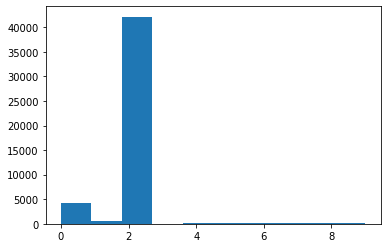

In [19]:
plt.hist(smb_chunks_int.flatten())

(array([ 2290.,     0.,  3200.,     0.,   152.,     0.,  7708.,     0.,
          400., 35146.]),
 array([11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ]),
 <a list of 10 Patch objects>)

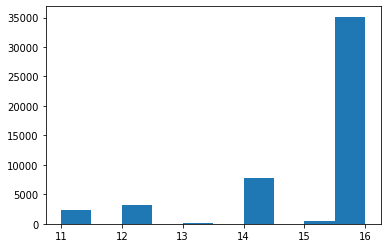

In [20]:
plt.hist(ki_chunks_int.flatten())

In [21]:
print(smb_chunks_int.shape)

(187, 16, 16)


In [22]:
print(ki_chunks_int.shape)

(191, 16, 16)


**Step 3**. Compute density and difficulty for each chunk.

In [23]:
char_to_int = { "X": 0,
                "S": 1,
                "-": 2,
                "?": 3,
                "Q": 4,
                "E": 5,
                "<": 6,
                ">": 7,
                "[": 8,
                "]": 9,
                "o": 10,
                "T": 11,
                "M": 12,
                "D": 13,
                "#": 14,
                "H": 15,
                "*": 16
              }

**Definition of max density.** We define a segment with density of 100% to have approximately 128 out of 256 tiles to be solid.

In [24]:
def density(array):
    """Compute the density of a 16-by-16 segment"""
    total = 0
    for line in array:
        total += len(line[line == 0]) # SMB ground
        total += len(line[line == 1]) # SMB breakable
        total += len(line[line == 3]) # SMB question
        total += len(line[line == 4]) # SMB question
        
        total += len(line[line == 11]) # T, KI platform
        total += len(line[line == 12]) # M, KI movable platform
        total += len(line[line == 14]) # #, KI ground
    max_density = 128
    return total / max_density * 100

**Definition of max difficulty.** We define a segment with difficulty of 100% to have approximately 16 total enemies and hazards.

In [25]:
def difficulty(array):
    """Compute the difficulty of a 16-by-16 segment"""
    num_eh = 0  # number of enemies and hazards
    for i, line in enumerate(array):
        num_eh += len(line[line == 5]) + len(line[line == 15])
    return num_eh / 16 * 100

In [26]:
sampled_densities = []
sampled_difficulties = []
for chunk in sampled_chunks_int:
    sampled_densities.append(density(chunk))
    sampled_difficulties.append(difficulty(chunk))

In [27]:
smb_densities = []
smb_difficulties = []
for chunk in smb_chunks_int:
    smb_densities.append(density(chunk))
    smb_difficulties.append(difficulty(chunk))

In [28]:
ki_densities = []
ki_difficulties = []
for chunk in ki_chunks_int:
    ki_densities.append(density(chunk))
    ki_difficulties.append(difficulty(chunk))

In [35]:
with open('sampled_densities_difficulties.json', 'w') as json_f:
    json.dump(np.stack([sampled_densities, sampled_difficulties]).T.tolist(), json_f)

In [36]:
with open('smb_densities_difficulties.json', 'w') as json_f:
    json.dump(np.stack([smb_densities, smb_difficulties]).T.tolist(), json_f)

In [38]:
with open('ki_densities_difficulties.json', 'w') as json_f:
    json.dump(np.stack([ki_densities, ki_difficulties]).T.tolist(), json_f)

**Step 4.** Plot expressive range of density vs. difficulty.

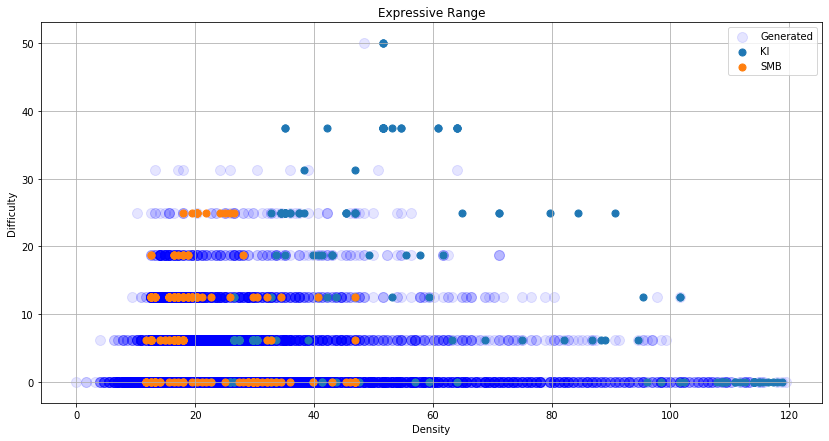

In [29]:
plt.figure(figsize=(14, 7))
plt.scatter(sampled_densities, sampled_difficulties, alpha=0.1, s=100, label='Generated', color='blue')
plt.scatter(ki_densities, ki_difficulties, alpha=1, s=50, label='KI')

plt.scatter(smb_densities, smb_difficulties, alpha=1, s=50, label='SMB')

plt.legend()
plt.grid()
plt.xlabel('Density')
plt.ylabel('Difficulty')
plt.title('Expressive Range')
plt.savefig('expressive_range.png', dpi=300)

## Plot histogram of game proportion (of each generated chunk)

In [38]:
def smb_density(array):
    total = 0
    for line in array:
        total += len(line[line == 0])
        total += len(line[line == 1])
        total += len(line[line == 2])
        total += len(line[line == 3])
        total += len(line[line == 4])
        total += len(line[line == 5])
        total += len(line[line == 6])
        total += len(line[line == 7])
        total += len(line[line == 8])
        total += len(line[line == 9])
        total += len(line[line == 10])
    max_density = 16 * 16
    return total / max_density * 100

In [39]:
def ki_density(array):
    total = 0
    for line in array:
        total += len(line[line == 11])
        total += len(line[line == 12])
        total += len(line[line == 13])
        total += len(line[line == 14])
        total += len(line[line == 15])
        total += len(line[line == 16])
    max_density = 16 * 16
    return total / max_density * 100

In [40]:
sampled_smb_densities = []
sampled_ki_densities = []
for chunk in sampled_chunks_int:
    sampled_smb_densities.append(smb_density(chunk))
    sampled_ki_densities.append(ki_density(chunk))

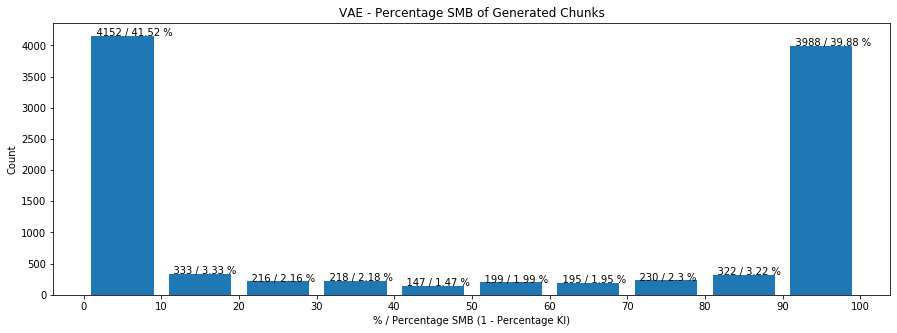

In [41]:
plt.figure(figsize=(15, 5))
counts, bins, _ = plt.hist(np.array(sampled_smb_densities), rwidth=0.8)

plt.xticks(np.arange(0, 101, 10))

plt.xlabel('% / Percentage SMB (1 - Percentage KI)')
plt.ylabel('Count')
plt.title('VAE - Percentage SMB of Generated Chunks')

total = np.sum(counts)

for count, _bin in zip(counts, bins):
    plt.annotate(f'    {int(count)} / {round(count/total*100, 3)} %', xy=(_bin, count), xycoords='data')

plt.show()

## Compute KL-Divergence with respect to uniform distribution

In [45]:
print('KL Divergence with Uniform Blending: ', entropy(np.array(counts)/total, [1/10 for i in range(10)]))
print('The more polarized (on either or both ends) our distribution is, the higher the KL divergence.')
print('Therefore, the lower the KL, the better ... for our purposes ...')

NameError: name 'counts' is not defined

## Reconstructions

In [277]:
print(train_chunks.size(), train_chunks.type())

torch.Size([378, 17, 16, 16]) torch.DoubleTensor


In [292]:
vae_trained.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(17, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten()
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=512, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [293]:
vae_trained.double().encode(train_chunks[:1000].cpu().double())[0][3]

tensor([ 8.3522e-02,  7.7142e-01,  6.6313e-02, -1.3700e-02, -9.8795e-01,
        -9.6013e-02,  4.2273e-01,  3.1316e-02, -6.0412e-04, -1.7082e-02,
         1.0765e-01,  1.4857e-02, -1.3670e-01, -1.4624e-02, -1.3215e-01,
        -4.8275e-01, -6.8108e-02,  3.2962e-04, -2.4927e-02, -4.8033e-02,
         1.0371e-01, -8.2698e-02, -1.5275e-01,  4.2662e-02, -8.2402e-02,
         1.2687e+00,  1.1668e-02, -9.2678e-01,  9.7065e-01,  4.9114e-02,
        -4.8147e-01, -6.2183e-02, -2.0538e-02, -4.5357e-02, -1.1026e+00,
        -2.2242e-02, -6.4586e-02, -3.1607e-01, -5.9476e-02,  6.2960e-02,
         1.0543e-01,  2.8283e-02, -1.5404e-02, -9.4531e-01,  1.1207e-01,
        -4.2883e-02,  4.1140e-01, -6.6926e-02, -2.8573e-01, -1.2211e+00,
         2.0444e-02,  3.1134e-02, -2.7291e-02, -2.8890e-01, -7.7685e-01,
         2.0645e-01, -2.3817e-02, -1.7863e-02,  1.8061e-01, -2.8644e-01,
         3.5410e-02, -2.4794e-01,  6.0909e-02,  1.9717e-02],
       dtype=torch.float64, grad_fn=<SelectBackward>)

In [294]:
vae_trained.cpu().double().encode(train_chunks[3].cpu().double().unsqueeze(0))[0]

tensor([[ 8.3522e-02,  7.7142e-01,  6.6313e-02, -1.3700e-02, -9.8795e-01,
         -9.6013e-02,  4.2273e-01,  3.1316e-02, -6.0412e-04, -1.7082e-02,
          1.0765e-01,  1.4857e-02, -1.3670e-01, -1.4624e-02, -1.3215e-01,
         -4.8275e-01, -6.8108e-02,  3.2962e-04, -2.4927e-02, -4.8033e-02,
          1.0371e-01, -8.2698e-02, -1.5275e-01,  4.2662e-02, -8.2402e-02,
          1.2687e+00,  1.1668e-02, -9.2678e-01,  9.7065e-01,  4.9114e-02,
         -4.8147e-01, -6.2183e-02, -2.0538e-02, -4.5357e-02, -1.1026e+00,
         -2.2242e-02, -6.4586e-02, -3.1607e-01, -5.9476e-02,  6.2960e-02,
          1.0543e-01,  2.8283e-02, -1.5404e-02, -9.4531e-01,  1.1207e-01,
         -4.2883e-02,  4.1140e-01, -6.6926e-02, -2.8573e-01, -1.2211e+00,
          2.0444e-02,  3.1134e-02, -2.7291e-02, -2.8890e-01, -7.7685e-01,
          2.0645e-01, -2.3817e-02, -1.7863e-02,  1.8061e-01, -2.8644e-01,
          3.5410e-02, -2.4794e-01,  6.0909e-02,  1.9717e-02]],
       dtype=torch.float64, grad_fn=<AddmmBackwar

In [257]:
vae_trained.double().cpu().encode(train_chunks.double().cpu())[0][15] - vae_trained.cpu().double().encode(train_chunks[15].cpu().double().unsqueeze(0))[0]

tensor([[-5.9113e-02, -5.2502e-01,  1.0712e-01, -3.8740e-02, -3.5113e-01,
          1.5114e-01, -1.2394e-01,  5.3199e-02,  9.9637e-02, -3.7531e-02,
         -6.8842e-01, -5.6347e-03,  4.6228e-02,  2.4790e-02, -1.8827e-01,
         -9.0202e-01, -6.6572e-02, -3.3911e-02, -4.0610e-01,  2.5015e-01,
          5.2549e-01,  7.3982e-02, -8.5249e-02,  6.4614e-03,  2.8199e-02,
          6.3629e-02,  3.6674e-02,  4.4033e-01, -2.0234e-01,  3.8261e-01,
          8.2527e-01,  3.2221e-01,  1.4521e-01, -4.8616e-01,  3.0842e-01,
          5.8716e-01, -1.2705e-03,  1.6496e-01, -3.6503e-01,  1.2371e-02,
          4.1585e-01,  6.0328e-03,  2.0544e-03, -5.2847e-01,  2.2092e-01,
          2.4766e-01, -5.2035e-01,  4.2462e-04,  1.4158e-01, -1.1599e+00,
          4.6680e-02,  5.4748e-02,  4.8733e-01, -1.3273e-02, -8.0206e-02,
         -1.9168e-01,  4.6515e-02, -3.2493e-01, -1.1827e-01,  6.7855e-02,
          1.0811e-01,  5.3303e-01,  6.1602e-01,  7.6844e-02]],
       dtype=torch.float64, grad_fn=<SubBackward0

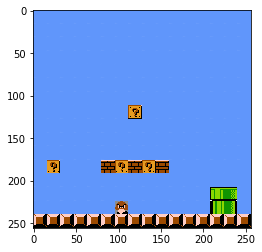

In [295]:
plt.imshow(array_to_image(vae_trained.double()(train_chunks[15].double().unsqueeze(0))[0].detach().numpy().argmax(axis=1)))

In [214]:
orgs_np = train_chunks.numpy().argmax(axis=1)  # training data

In [215]:
rec_from_org = vae_trained(torch.from_numpy(np.rollaxis(np.eye(17)[orgs_np[15]][None], 3, 1)))[0].detach().numpy().argmax(axis=1)



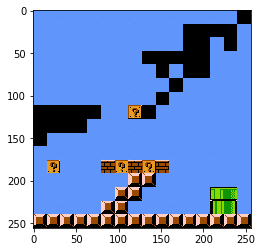

In [216]:
plt.imshow(array_to_image(rec_from_org))

In [217]:
zs, mus, logvars = vae_trained.encode(train_chunks)

In [218]:
recs, mus, logvars = vae_trained(train_chunks)  # get reconstructions

In [219]:
recs_np = recs.detach().numpy().argmax(axis=1)

In [208]:
print(recs_np.shape)

(378, 16, 16)


In [209]:
np.array([[1, 2, 3]])[None]

array([[[1, 2, 3]]])

In [296]:
with open('data/smb_chunk_15.txt') as f:
    chunk = f.read().split('\n')
    for i, line in enumerate(chunk):
        chunk[i] = list(line)

In [297]:
for i, line in enumerate(chunk):
    for j, char in enumerate(line):
        chunk[i][j] = char_to_int[char]

In [298]:
chunk_int = np.array(chunk[:-1], dtype='int')

In [299]:
chunk_onehot = np.rollaxis(np.eye(17)[chunk_int], 2, 0)

In [300]:
chunks_onehot = np.array([chunk_onehot for i in range(500)])

In [301]:
chunks_onehot.shape

(500, 17, 16, 16)

In [302]:
reconstructed = vae_trained(torch.from_numpy(chunks_onehot).double())[0].detach().numpy().argmax(axis=1)

In [228]:
reconstructed.shape

(500, 16, 16)

In [229]:
chunk_int - orgs_np[15]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [230]:
orgs_np[15]

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 4, 2, 2, 2, 1, 3, 1, 4, 1, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 7, 2],
       [2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 8, 9, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

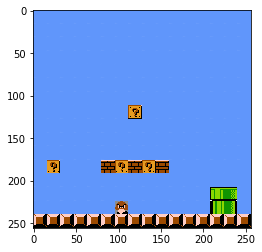

In [303]:
plt.imshow(array_to_image([reconstructed[3]]))
plt.show()

In [240]:
vae_trained.encode(train_chunks)

(tensor([[ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02, -8.7220e-04],
         [ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02, -8.7220e-04],
         [ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02, -8.7220e-04],
         ...,
         [ 1.6822e+00,  2.0961e+00,  7.1083e-02,  ..., -3.2074e-01,
           1.6325e+00,  3.8585e-03],
         [ 1.0152e+00,  1.0445e-01,  5.1351e-02,  ...,  9.0751e-02,
          -3.7636e-02, -4.1121e-02],
         [-6.5224e-01,  1.0055e+00, -5.3580e-02,  ...,  6.7440e-01,
          -8.1204e-02, -3.3642e-02]], dtype=torch.float64,
        grad_fn=<AddmmBackward>),
 tensor([[ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02, -8.7220e-04],
         [ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02, -8.7220e-04],
         [ 2.4811e-02,  4.8775e-02,  6.6393e-02,  ..., -3.5406e-01,
          -5.1490e-02,

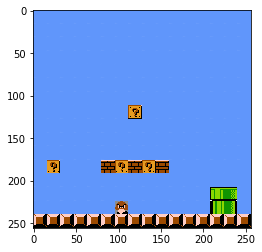

In [234]:
plt.imshow(array_to_image([recs_np[15]]))

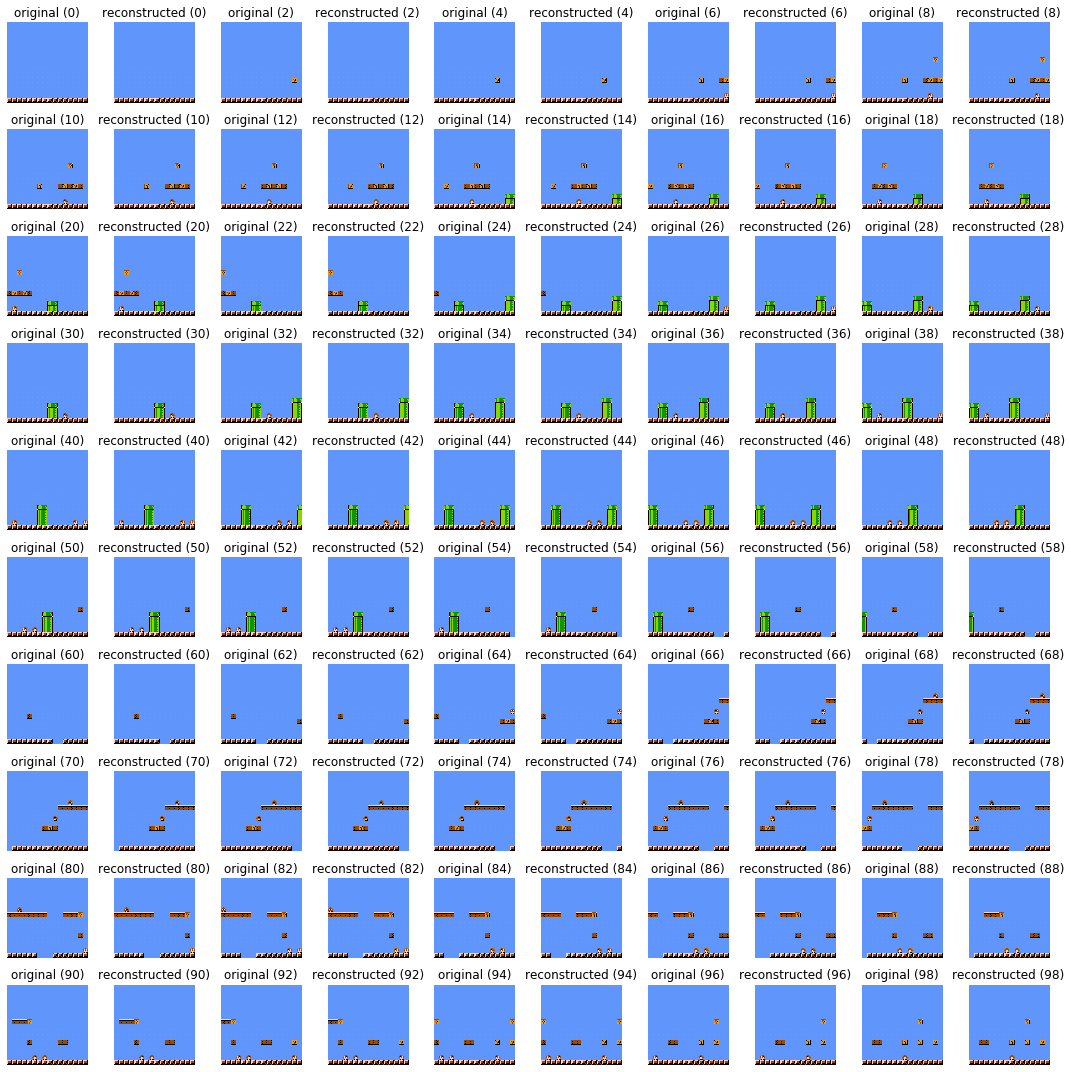

In [235]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
fig.subplots_adjust(hspace=0, wspace=0)

for i in range(10):
    for j in range(10):
        
        if j % 2 == 0:
            
            axes[i, j].imshow(array_to_image([orgs_np[(i*10 + j + 0)]]))
            axes[i, j].axis('off')
            label = f'original ({i * 10 + j})'
            axes[i, j].title.set_text(label)

            axes[i, j+1].imshow(array_to_image([recs_np[(i*10 + j + 0)]]))
            axes[i, j+1].axis('off')
            label = f'reconstructed ({i * 10 + j})' 
            axes[i, j+1].title.set_text(label)
            
            
plt.tight_layout()
plt.show()

---

# Miscellaneous experiments (don't worry about this)

Ignore this section if you want. This section is just a test ground of ideas.

## Observe reconstruction loss over tim

In [116]:
char_to_int = {
    "#": 0,
    "T": 1,
    "M": 2,
    
    "H": 3,

    "0": 4,
    "D": 5,
    
    "-": 6,
    "X": 7,
    "S": 8,
    "=": 9,
    
    "Q": 10,
    "o": 11,
    "E": 12,
    
    "<": 13,
    ">": 14, 
    "[": 15,
    "]": 16
}

int_to_char = {v:k for k, v in char_to_int.items()}

char_to_tile_name = {
    "#": 'ki-unpassable',
    "T": 'ki-passable',
    "M": 'ki-moving-platform',
    
    "H": 'ki-hazard',

    "0": 'ki-background',
    "D": 'ki-door',
    
    "-": 'smb-background',
    "X": 'smb-unpassable',
    "S": 'smb-breakable',
    "=": 'smb-movable-platform',
    
    "Q": 'smb-question',
    "o": 'smb-coin',
    "E": 'smb-enemy',
    
    "<": 'smb-tube-top-left',
    ">": 'smb-tube-top-right',
    "[": 'smb-tube-lower-left',
    "]": 'smb-tube-lower-right',
    }

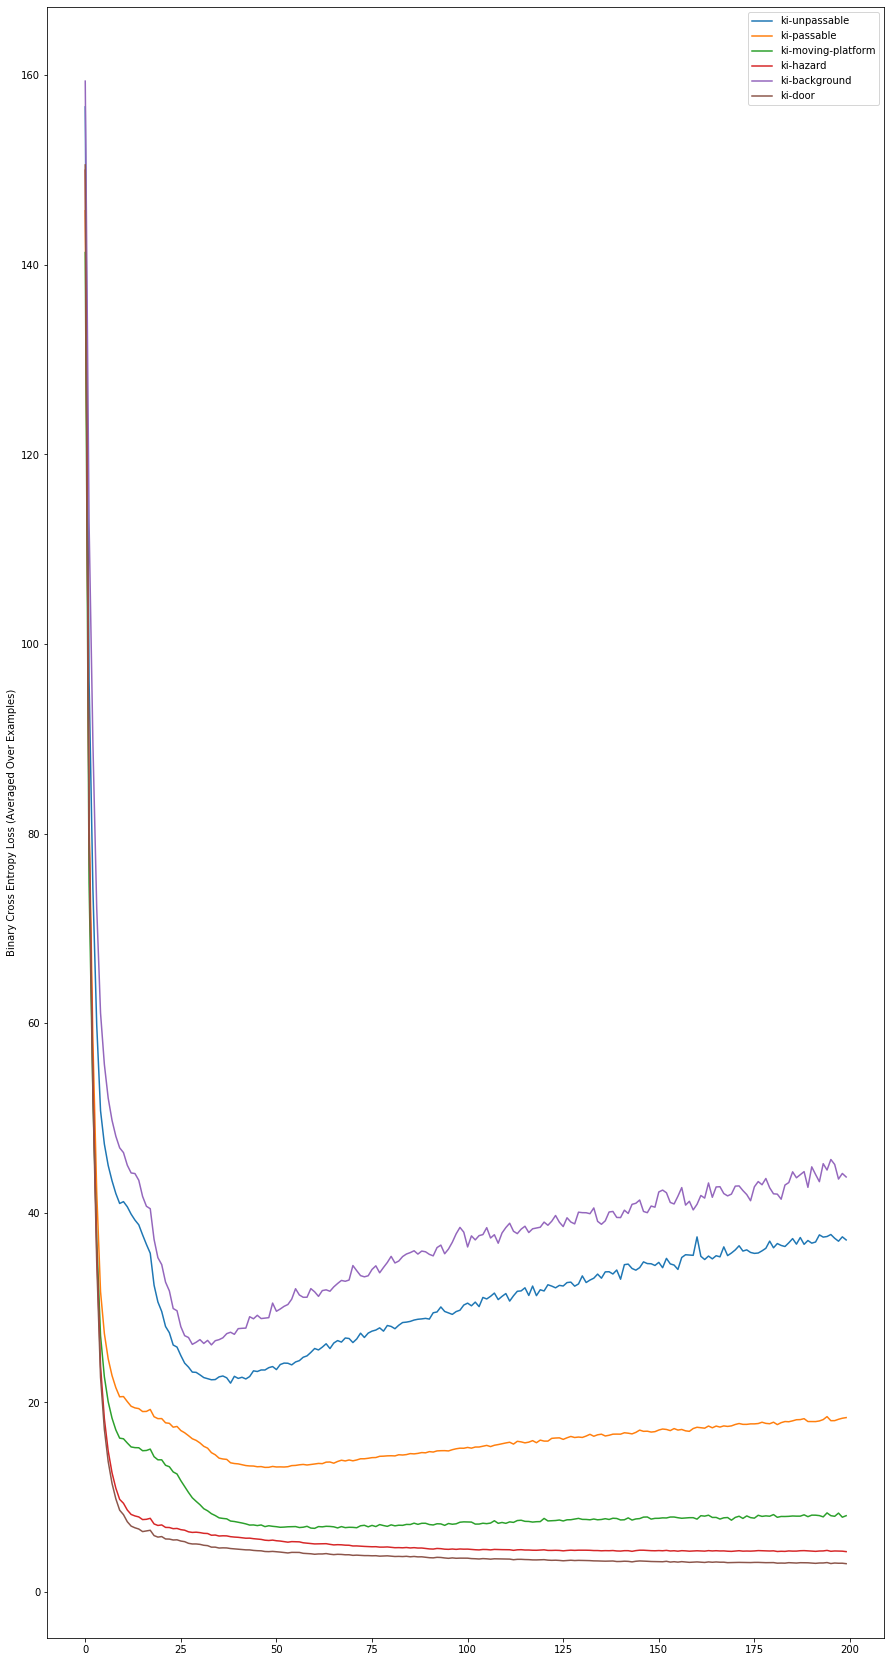

In [125]:
plt.figure(figsize=(15, 15))
for index, loss in enumerate(loss_per_type_processed[:6]):
    plt.plot(loss[5:200], label=char_to_tile_name[int_to_char[index]])
plt.legend()
plt.ylabel('Binary Cross Entropy Loss (Averaged Over Examples)')
plt.show()

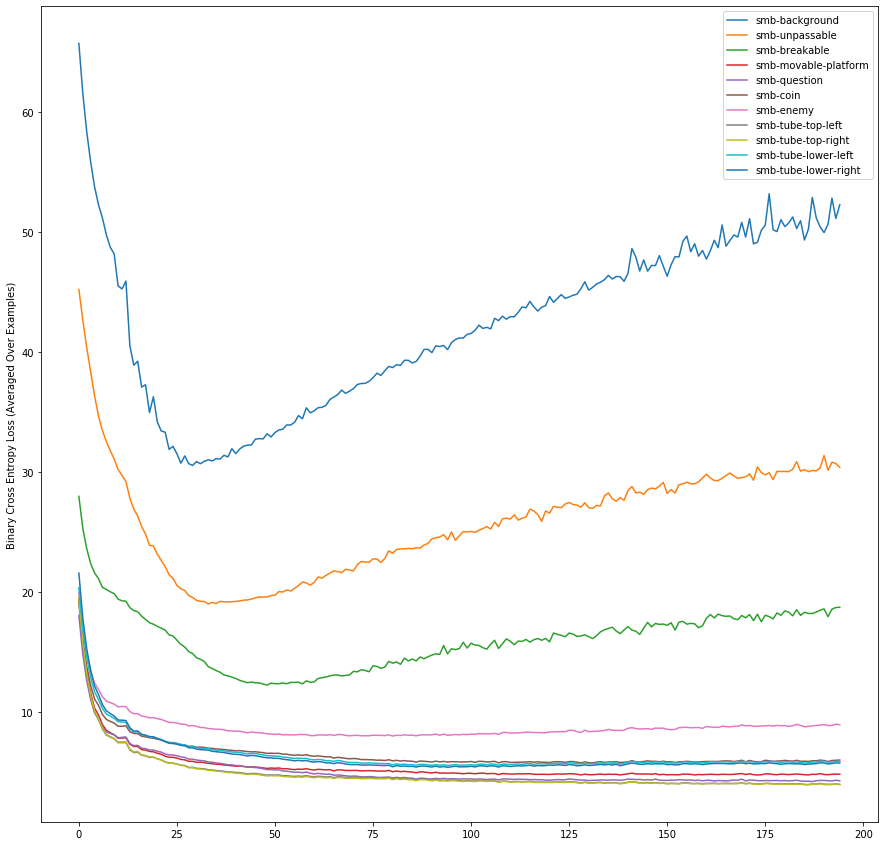

In [128]:
plt.figure(figsize=(15, 15))
for index, loss in enumerate(loss_per_type_processed[6:]):
    plt.plot(loss[5:200], label=char_to_tile_name[int_to_char[index+6]])
plt.legend()
plt.ylabel('Binary Cross Entropy Loss (Averaged Over Examples)')
plt.show()